<a href="https://colab.research.google.com/github/11330344/Thesis-Project/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the data and preprocess it
df = pd.read_csv('/content/drive/MyDrive/Thesis2024/fer2013.csv')
df = df[(df['emotion'] != 1) & (df['emotion'] != 5)]  # Remove disgust and surprise emotions

pixels = df['pixels'].tolist()
X = np.array([np.fromstring(pixel, dtype=int, sep=' ') for pixel in pixels])
X = X.reshape(-1, 48, 48, 1) / 255.0  # Normalize pixel values
y = df['emotion'].values

encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = pd.get_dummies(y).values  # Convert to one-hot encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))  # Additional dense layer
model.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

# Save the model architecture as a JSON file
model_json = model.to_json()
with open('/content/drive/MyDrive/Thesis2024/model.json', 'w') as json_file:
    json_file.write(model_json)


Epoch 1/50
196/196 [==============================] - 4s 14ms/step - loss: 1.5823 - accuracy: 0.2865 - val_loss: 1.5607 - val_accuracy: 0.3003
Epoch 2/50
196/196 [==============================] - 2s 11ms/step - loss: 1.5313 - accuracy: 0.3321 - val_loss: 1.4798 - val_accuracy: 0.3904
Epoch 3/50
196/196 [==============================] - 3s 13ms/step - loss: 1.4325 - accuracy: 0.4056 - val_loss: 1.3818 - val_accuracy: 0.4346
Epoch 4/50
196/196 [==============================] - 2s 11ms/step - loss: 1.3669 - accuracy: 0.4345 - val_loss: 1.3320 - val_accuracy: 0.4531
Epoch 5/50
196/196 [==============================] - 2s 11ms/step - loss: 1.3190 - accuracy: 0.4558 - val_loss: 1.2938 - val_accuracy: 0.4729
Epoch 6/50
196/196 [==============================] - 2s 11ms/step - loss: 1.2806 - accuracy: 0.4775 - val_loss: 1.2650 - val_accuracy: 0.4799
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 1.2502 - accuracy: 0.4900 - val_loss: 1.2432 - val_accuracy: 0.5002

# New section

In [6]:
# Print model summary
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

196/196 [==============================] - 0s 2ms/step


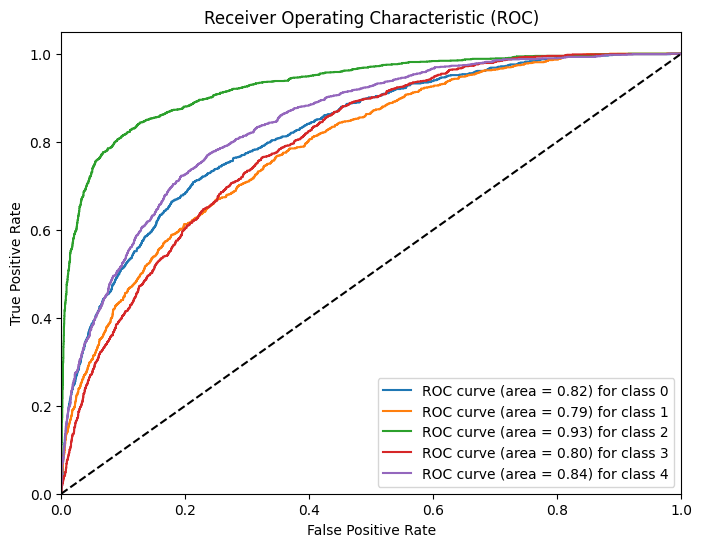

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [14]:
from sklearn.metrics import f1_score

import numpy as np

# Get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Get predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to labels
y_true = np.argmax(y_test, axis=1)

# Compute F1 score for each class
f1_scores = f1_score(y_true, y_pred, average=None)

# Print F1 score for each class
for i, f1 in enumerate(f1_scores):
    print(f"F1 score for class {i}: {f1:.2f}")



196/196 [==============================] - 1s 3ms/step
F1 score for class 0: 0.48
F1 score for class 1: 0.46
F1 score for class 2: 0.79
F1 score for class 3: 0.47
F1 score for class 4: 0.54


In [19]:

from sklearn.metrics import f1_score

# Get predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to labels
y_true = np.argmax(y_test, axis=1)

# Compute F1 score for the entire model
f1 = f1_score(y_true, y_pred, average='weighted')  # or average='macro'

print("F1 score for the entire model:", f1)



F1 score for the entire model: 0.5751157930129313


196/196 [==============================] - 1s 5ms/step


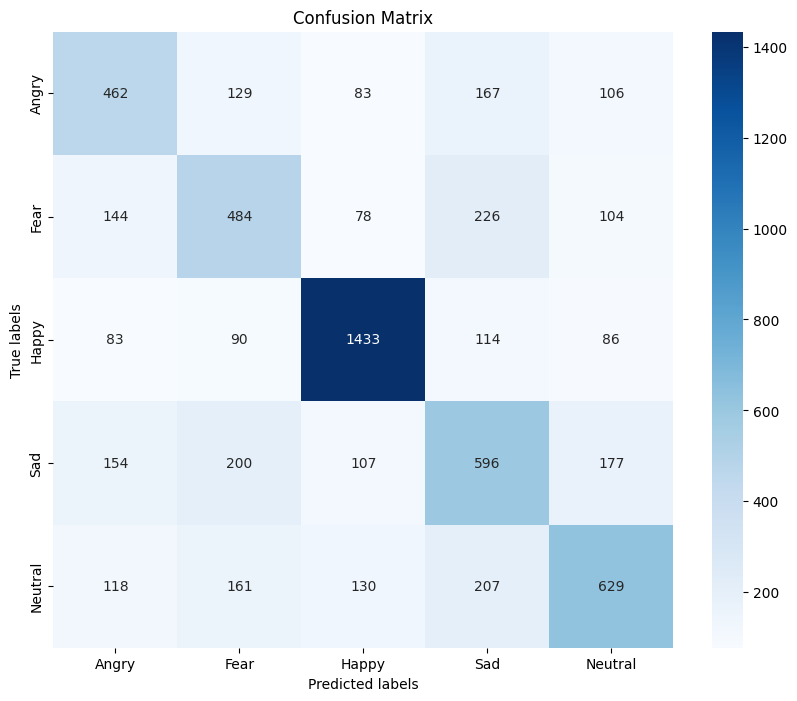

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to labels
y_true = np.argmax(y_test, axis=1)

# Define emotions list without "Disgust" and "Surprise"
emotions = ["Angry", "Fear", "Happy", "Sad", "Neutral"]

# Define the confusion matrix with all classes
conf_matrix = confusion_matrix(y_true, y_pred)

# Remove rows and columns corresponding to "Disgust" and "Surprise" if they exist
if conf_matrix.shape[0] > 5 and conf_matrix.shape[1] > 5:
    conf_matrix_filtered = np.delete(conf_matrix, [1, 5], axis=0)  # Remove rows corresponding to "Disgust" and "Surprise"
    conf_matrix_filtered = np.delete(conf_matrix_filtered, [1, 5], axis=1)  # Remove columns corresponding to "Disgust" and "Surprise"
else:
    conf_matrix_filtered = conf_matrix

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_filtered, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


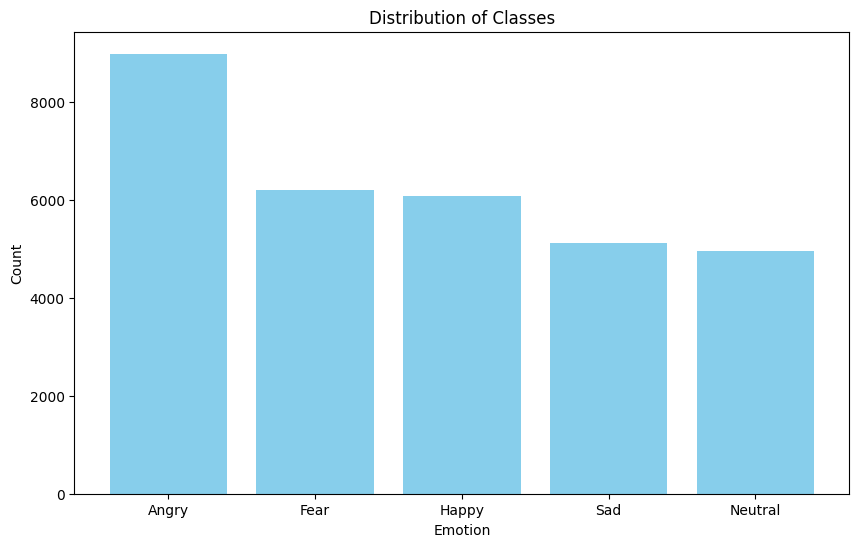

In [36]:
import matplotlib.pyplot as plt

# Calculate the count of each class
class_counts = df['emotion'].value_counts()

# Define emotions list without "Disgust" and "Surprise"
emotions = ["Angry", "Fear", "Happy", "Sad", "Neutral"]

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
plt.bar(emotions, class_counts, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()


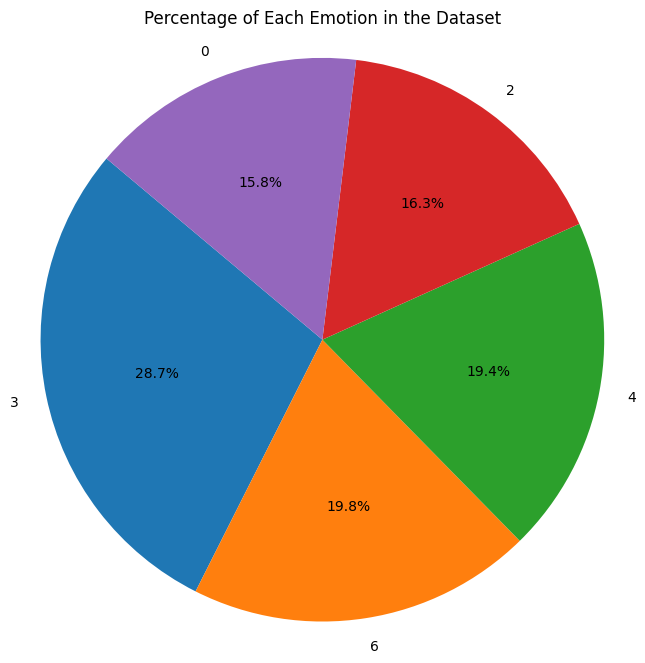

In [39]:
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame 'df' with emotion labels
# Count the occurrences of each emotion
emotion_counts = df['emotion'].value_counts()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Each Emotion in the Dataset')
plt.show()


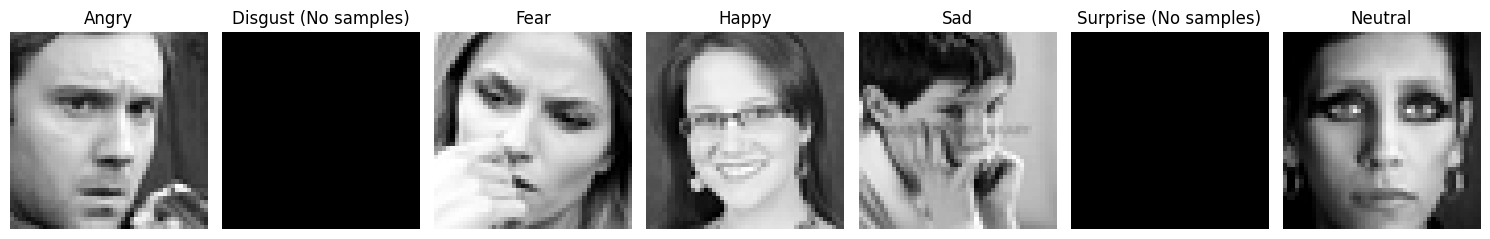

In [44]:
import matplotlib.pyplot as plt

# Define emotions and their corresponding labels
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Create a figure with subplots for each emotion
fig, axes = plt.subplots(1, len(emotions), figsize=(15, 3))

# Iterate over each emotion and find a sample for that emotion
for i, emotion in enumerate(emotions):
    try:
        # Find the first sample with the current emotion label
        sample = df[df['emotion'] == i].iloc[0]

        # Convert the pixel values to an array and reshape it to the original image dimensions
        pixels = np.array(sample['pixels'].split(), dtype='int').reshape(48, 48)

        # Display the image in the corresponding subplot
        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(emotion)
        axes[i].axis('off')
    except IndexError:
        # If there are no samples for the current emotion, display a placeholder image
        axes[i].imshow(np.zeros((48, 48)), cmap='gray')
        axes[i].set_title(emotion + " (No samples)")
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [47]:
from sklearn.metrics import classification_report

# Get predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Convert probabilities to predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to labels
y_true = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)


196/196 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       947
           1       0.45      0.47      0.46      1036
           2       0.78      0.79      0.79      1806
           3       0.45      0.48      0.47      1234
           4       0.57      0.51      0.54      1245

    accuracy                           0.57      6268
   macro avg       0.55      0.55      0.55      6268
weighted avg       0.58      0.57      0.58      6268

